In [2]:
import findspark
findspark.init()

In [6]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import  KMeans
from pyspark.sql import SQLContext
import pandas as pd
import glob
import yaml
import csv
import numpy as np

In [7]:
spark = SparkSession.builder.appName('player-clustering').getOrCreate()
df = spark.read.options(header="true",
                               inferSchema="true",
                               nullValue="-",
                               mode="failfast").csv("hdfs://localhost:9000/batting.csv")

df_d = spark.read.options(header="true",
                               inferSchema="true",
                               nullValue="-",
                               mode="failfast").csv("hdfs://localhost:9000/DebutantBattingData.csv")

df_d = df_d.select('Player','Inns','Runs','HS','Ave','BF','SR')
df.show()
df_d.show()

+------------+---+----+---+----+---+-----+---+------+---+---+---+---+---+--------------------+----+
|      Player|Mat|Inns| NO|Runs| HS|  Ave| BF|    SR|100| 50|  0| 4s| 6s|            TeamName|Year|
+------------+---+----+---+----+---+-----+---+------+---+---+---+---+---+--------------------+----+
|    VR Aaron| 10|   3|  3|  35| 17|  0.0| 34|102.94|  0|  0|  0|  2|  1|Royal Challengers...|2014|
|  MA Agarwal|  8|   8|  0| 115| 31|14.37| 91|126.37|  0|  0|  0| 12|  3|    Delhi Daredevils|2014|
|    AN Ahmed|  4|   1|  1|   4|  4|  0.0|  1| 400.0|  0|  0|  0|  1|  0|Royal Challengers...|2014|
| CJ Anderson| 12|  11|  2| 265| 95|29.44|181| 146.4|  0|  1|  0| 21| 15|      Mumbai Indians|2014|
|  S Anirudha|  1|   1|  0|   3|  3|  3.0|  5|  60.0|  0|  0|  0|  0|  0| Sunrisers Hyderabad|2014|
|Ankit Sharma|  3|   2|  0|  34| 30| 17.0| 30|113.33|  0|  0|  0|  4|  1|    Rajasthan Royals|2014|
|    R Ashwin| 16|   6|  3|  45| 14| 15.0| 45| 100.0|  0|  0|  0|  4|  0| Chennai Super Kings|2014|


In [8]:
df.rdd.getNumPartitions()


1

In [9]:
dfBowl = spark.read.options(header="true",
                               inferSchema="true",
                               nullValue="-",
                               mode="failfast").csv("hdfs://localhost:9000/bowling.csv")

dfBowl_d = spark.read.options(header="true",
                               inferSchema="true",
                               nullValue="-",
                               mode="failfast").csv("hdfs://localhost:9000/DebutantBowlingData.csv")

dfBowl_d = dfBowl_d.select('Player','Inns','Runs','Wkts','Ave','Econ','SR')

In [10]:
dfBowl.rdd.getNumPartitions()

1

In [11]:
df5 = df.rdd.repartition(5).toDF()
df5.rdd.getNumPartitions()

5

In [12]:
dfBowl5 = dfBowl.rdd.repartition(5).toDF()
dfBowl5.rdd.getNumPartitions()

5

In [13]:
df5.printSchema()

root
 |-- Player: string (nullable = true)
 |-- Mat: long (nullable = true)
 |-- Inns: long (nullable = true)
 |-- NO: long (nullable = true)
 |-- Runs: long (nullable = true)
 |-- HS: long (nullable = true)
 |-- Ave: double (nullable = true)
 |-- BF: long (nullable = true)
 |-- SR: double (nullable = true)
 |-- 100: long (nullable = true)
 |-- 50: long (nullable = true)
 |-- 0: long (nullable = true)
 |-- 4s: long (nullable = true)
 |-- 6s: long (nullable = true)
 |-- TeamName: string (nullable = true)
 |-- Year: long (nullable = true)



In [14]:
dfBowl5.printSchema()

root
 |-- Player: string (nullable = true)
 |-- Mat: double (nullable = true)
 |-- Inns: double (nullable = true)
 |-- Overs: double (nullable = true)
 |-- Mdns: double (nullable = true)
 |-- Runs: double (nullable = true)
 |-- Wkts: double (nullable = true)
 |-- BBI: string (nullable = true)
 |-- Ave: double (nullable = true)
 |-- Econ: double (nullable = true)
 |-- SR: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- Ct: double (nullable = true)
 |-- St: double (nullable = true)
 |-- Year: long (nullable = true)



In [15]:
data = df5.select('Player','Year','Inns','Runs','HS','Ave','BF','SR')
#data.show()
#data2018=data[(data['Year']=='2018')]
#datan18=data[(data['Year']!='2018')]
data.printSchema()
data=data[(data['Year']!='2018')].toPandas()
data=data.drop(['Year'], axis=1)
df_d = df_d.toPandas()
data = data.append(df_d)
data['Runs']=data['Runs']/data['BF']
data = data.groupby('Player',as_index=False).agg({'Inns':sum,'Runs':sum,'HS':max,'Ave': np.mean,'BF':sum,'SR': np.mean})
print(data)
print(type(data))
print(data.info)
#data2018=data2018.toPandas()
#datan18=datan18.toPandas()
#print(data2018)
#count=0
#counts=[]
#datan18.groupby(['Player']).count()

#for i in range(len(datan18)):
#    continue
    
# data2018.iloc[i]['Player']

root
 |-- Player: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Inns: long (nullable = true)
 |-- Runs: long (nullable = true)
 |-- HS: long (nullable = true)
 |-- Ave: double (nullable = true)
 |-- BF: long (nullable = true)
 |-- SR: double (nullable = true)

                Player  Inns      Runs   HS        Ave    BF          SR
0       A Ashish Reddy     8  3.207646   32  23.915000    75  160.375000
1          A Choudhary     3  1.250000   15  25.000000    20  125.000000
2          A Dananjaya    19  0.820225   28   7.300000    89   82.020000
3             A Mishra    14  2.466117   13  14.750000    85   61.650000
4              A Nehra     8  1.142857    1   0.250000     8   28.570000
5              A Zampa     2  0.714286    5   2.500000     8   35.710000
6             AB Dinda     4  1.333333    7   2.750000    19   33.332500
7       AB de Villiers    52  6.350313  133  40.592500  1112  158.752500
8             AD Hales   190  1.422992  116  29.060000  3636  14

In [16]:
dataBowl = dfBowl5.select('Player','Year','Inns','Runs','Wkts','Ave','Econ','SR') 
dataBowl = dataBowl[(dataBowl['Year']!='2018')] 
dataBowl = dataBowl[(dataBowl['Year']!='2018')].toPandas()
dataBowl = dataBowl.drop(['Year'], axis=1) 
dfBowl_d = dfBowl_d.toPandas()
dataBowl = dataBowl.append(dfBowl_d)
dataBowl['Runs'] = dataBowl['Runs']/dataBowl['Inns']
dataBowl['Wkts'] = dataBowl['Wkts']/dataBowl['Inns']
dataBowl = dataBowl.groupby('Player', as_index=False).agg({'Inns':sum,'Runs':sum,'Econ':np.mean,'Ave': np.mean,'SR': np.mean,'Wkts':sum})

print(dataBowl) 
print(type(dataBowl))

#dataBowl.show()

                Player  Inns        Runs       Econ        Ave         SR  \
0       A Ashish Reddy   6.0   32.000000   9.250000  27.830000  17.500000   
1          A Choudhary   5.0   28.800000   8.550000  28.800000  20.200000   
2          A Dananjaya  51.0   25.725490   7.220000  23.420000  19.400000   
3             A Mishra  50.0  108.904762   8.267500  35.942500  25.825000   
4              A Nehra  34.0  121.270833   8.412500  21.220000  15.300000   
5              A Zampa  11.0   50.166667   7.485000  16.430000  12.750000   
6             AB Dinda  23.0  126.333333  10.142500  48.500000  28.450000   
7       AB de Villiers   0.0    0.000000   0.000000   0.000000   0.000000   
8             AD Hales   2.0    3.500000  14.000000   0.000000   0.000000   
9           AD Mathews  12.0   52.600000   9.700000  17.570000  12.850000   
10             AD Nath   0.0    0.000000   0.000000   0.000000   0.000000   
11          AD Russell  27.0   75.173077   8.776667  31.513333  20.666667   

In [17]:
from pyspark.sql.types import *

print(data.dtypes)
mySchema = StructType([StructField("Player", StringType(), True), StructField("Inns", LongType(), True), StructField("Runs", FloatType(), True), StructField("HS", LongType(), True), StructField("Ave", FloatType(), True), StructField("BF", LongType(), True), StructField("SR", FloatType(), True)])
data = spark.createDataFrame(data,schema=mySchema)
features=['Inns','Runs','HS','Ave','BF','SR']
for c in data.columns:
    if c in features:
        data= data.withColumn(c,data[c].cast('float'))
data.show()

Player     object
Inns        int64
Runs      float64
HS          int64
Ave       float64
BF          int64
SR        float64
dtype: object
+--------------+-----+----------+-----+---------+------+--------+
|        Player| Inns|      Runs|   HS|      Ave|    BF|      SR|
+--------------+-----+----------+-----+---------+------+--------+
|A Ashish Reddy|  8.0| 3.2076461| 32.0|   23.915|  75.0| 160.375|
|   A Choudhary|  3.0|      1.25| 15.0|     25.0|  20.0|   125.0|
|   A Dananjaya| 19.0| 0.8202247| 28.0|      7.3|  89.0|   82.02|
|      A Mishra| 14.0| 2.4661171| 13.0|    14.75|  85.0|   61.65|
|       A Nehra|  8.0| 1.1428572|  1.0|     0.25|   8.0|   28.57|
|       A Zampa|  2.0|0.71428573|  5.0|      2.5|   8.0|   35.71|
|      AB Dinda|  4.0| 1.3333334|  7.0|     2.75|  19.0| 33.3325|
|AB de Villiers| 52.0| 6.3503127|133.0|  40.5925|1112.0|158.7525|
|      AD Hales|190.0| 1.4229923|116.0|    29.06|3636.0|  142.29|
|    AD Mathews| 12.0| 2.5698006| 31.0|   18.285| 131.0| 128.485|
| 

In [18]:
print(dataBowl.dtypes)
myBowlSchema = StructType([StructField("Player", StringType(), True), StructField("SR", FloatType(), True), StructField("Wkts", FloatType(), True), StructField("Econ", FloatType(), True), StructField("Inns", FloatType(), True), StructField("Runs", FloatType(), True), StructField("Ave", FloatType(), True)])
dataBowl = spark.createDataFrame(dataBowl,schema=myBowlSchema)

features_ball=['Inns','Runs','Wkts','Ave','Econ','SR']
for c in dataBowl.columns:
    if c in features_ball:
        dataBowl= dataBowl.withColumn(c,dataBowl[c].cast('float'))
dataBowl.show()

Player     object
Inns      float64
Runs      float64
Econ      float64
Ave       float64
SR        float64
Wkts      float64
dtype: object
+--------------+----+----------+--------+---------+---------+---------+
|        Player|  SR|      Wkts|    Econ|     Inns|     Runs|      Ave|
+--------------+----+----------+--------+---------+---------+---------+
|A Ashish Reddy| 6.0|      32.0|    9.25|    27.83|     17.5|     1.25|
|   A Choudhary| 5.0|      28.8|    8.55|     28.8|     20.2|      1.0|
|   A Dananjaya|51.0|  25.72549|    7.22|    23.42|     19.4|1.0980393|
|      A Mishra|50.0| 108.90476|  8.2675|  35.9425|   25.825|3.0928571|
|       A Nehra|34.0|121.270836|  8.4125|    21.22|     15.3|5.8333335|
|       A Zampa|11.0| 50.166668|   7.485|    16.43|    12.75|3.5666666|
|      AB Dinda|23.0|126.333336| 10.1425|     48.5|    28.45|2.1111112|
|AB de Villiers| 0.0|       0.0|     0.0|      0.0|      0.0|      0.0|
|      AD Hales| 2.0|       3.5|    14.0|      0.0|      0.0|      0

In [19]:
features=['Runs','HS','Ave','BF','SR']
vec = VectorAssembler(inputCols=features, outputCol="features")
df_clus = vec.transform(data).select('Player','features')
df_clus.show()

+--------------+--------------------+
|        Player|            features|
+--------------+--------------------+
|A Ashish Reddy|[3.20764613151550...|
|   A Choudhary|[1.25,15.0,25.0,2...|
|   A Dananjaya|[0.82022470235824...|
|      A Mishra|[2.46611714363098...|
|       A Nehra|[1.14285719394683...|
|       A Zampa|[0.71428573131561...|
|      AB Dinda|[1.33333337306976...|
|AB de Villiers|[6.35031270980835...|
|      AD Hales|[1.42299234867095...|
|    AD Mathews|[2.56980061531066...|
|       AD Nath|[0.74074071645736...|
|    AD Russell|[3.82811689376831...|
|      AF Milne|[0.58333331346511...|
|      AJ Finch|[4.84736680984497...|
|        AJ Tye|[1.76666665077209...|
|      AM Nayar|[0.91489362716674...|
|     AM Rahane|[4.92160797119140...|
|      AN Ahmed|[6.0,5.0,5.0,6.0,...|
|       AP Tare|[3.42518568038940...|
|      AR Bawne|[1.0,12.0,0.0,12....|
+--------------+--------------------+
only showing top 20 rows



In [20]:
features_ball=['Runs','Wkts','Ave','Econ','SR']
vec_ball = VectorAssembler(inputCols=features_ball, outputCol="features_ball")
df_clus_ball = vec_ball.transform(dataBowl).select('Player','features_ball')
df_clus_ball.show()

+--------------+--------------------+
|        Player|       features_ball|
+--------------+--------------------+
|A Ashish Reddy|[17.5,32.0,1.25,9...|
|   A Choudhary|[20.2000007629394...|
|   A Dananjaya|[19.3999996185302...|
|      A Mishra|[25.8250007629394...|
|       A Nehra|[15.3000001907348...|
|       A Zampa|[12.75,50.1666679...|
|      AB Dinda|[28.4500007629394...|
|AB de Villiers|           (5,[],[])|
|      AD Hales|[0.0,3.5,0.0,14.0...|
|    AD Mathews|[12.8500003814697...|
|       AD Nath|           (5,[],[])|
|    AD Russell|[20.6666660308837...|
|      AF Milne|[26.0,76.5,1.75,1...|
|      AJ Finch|           (5,[],[])|
|        AJ Tye|[10.5,23.5,2.0,6....|
|      AM Nayar|           (5,[],[])|
|     AM Rahane|           (5,[],[])|
|      AN Ahmed|[50.2999992370605...|
|       AP Tare|           (5,[],[])|
|      AR Bawne|           (5,[],[])|
+--------------+--------------------+
only showing top 20 rows



In [21]:
error = np.zeros(15)
for k in range(2,15):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_clus.sample(False,0.25, seed=1))
    error[k] = model.computeCost(df_clus) 

In [22]:
errorBowl = np.zeros(15)
for k in range(2,15):
    kmeans_ball = KMeans().setK(k).setSeed(1).setFeaturesCol("features_ball")
    model_ball = kmeans_ball.fit(df_clus_ball.sample(False,0.25, seed=1))
    errorBowl[k] = model_ball.computeCost(df_clus_ball) 

[       0.                0.         41857359.74339804 11370377.03201301
  7069016.3911489   3460158.36387041  2643884.32925348  2288409.19786205
  1965506.22073869  1615081.36619433  1494146.89543021  1350889.43868891
  1169300.42572418  1005513.99321381   878340.03289843]


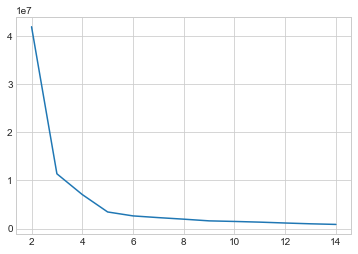

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

ax.plot(range(2,15),error[2:15])
print(error)

[     0.              0.         270726.31187917 209472.33379253
 141311.98263485 116228.71932185  75997.24174308  70662.06013074
  59233.0904738   48970.93767417  47050.10523075  46878.37932801
  37061.73402526  42802.334503    42798.67084163]


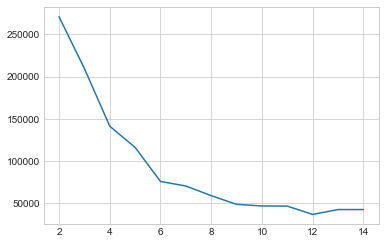

In [24]:
plt.style.use('seaborn-whitegrid')
fig_bowl = plt.figure()
ax_bowl = plt.axes()

ax_bowl.plot(range(2,15),errorBowl[2:15])
print(errorBowl)

In [25]:
k = 4
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_clus)
centers = model.clusterCenters()

print("Centers: ")
for i in range(len(centers)):
    print(i+1,": ",centers[i])

Centers: 
1 :  [ 1.53070586 16.76        8.74507085 39.685      80.53724171]
2 :  [  4.70636603  90.17647059  30.67723022 967.11764706 130.57048977]
3 :  [   2.8031128   118.83333333   34.54083347 2144.83333333  140.58416748]
4 :  [  3.41573001  69.02        23.97846657 360.14       129.26141678]


In [26]:
k = 5
kmeans_ball = KMeans().setK(k).setSeed(1).setFeaturesCol("features_ball")
model_ball = kmeans_ball.fit(df_clus_ball)
centers_ball = model_ball.clusterCenters()

print("Centers: ")
for i in range(len(centers_ball)):
    print(i+1,": ",centers_ball[i])

Centers: 
1 :  [24.30606056 63.98546829  1.81156256  8.84480302 15.87272727]
2 :  [0.07446809 1.58510638 0.01595745 1.01958333 0.24468085]
3 :  [ 23.22333338 108.80508287   3.39117235   8.63044443  34.24444444]
4 :  [ 18.97999992  25.93037338   1.06053593   7.84000015 122.2       ]
5 :  [23.0851648  28.76062888  0.83621652  8.49619962 10.05494505]


In [27]:
bat_preds = model.transform(df_clus).select('Player','features','prediction')
bat_r = bat_preds.collect()
bat = pd.DataFrame(bat_r)
bat.columns = ['Player', 'Features', 'Cluster']
bat.head()

,Player,Features,Cluster
0,A Ashish Reddy,"[3.207646131515503, 32.0, 23.915000915527344, ...",0
1,A Choudhary,"[1.25, 15.0, 25.0, 20.0, 125.0]",0
2,A Dananjaya,"[0.8202247023582458, 28.0, 7.300000190734863, ...",0
3,A Mishra,"[2.4661171436309814, 13.0, 14.75, 85.0, 61.650...",0
4,A Nehra,"[1.1428571939468384, 1.0, 0.25, 8.0, 28.569999...",0


In [28]:
ball_preds = model_ball.transform(df_clus_ball).select('Player','features_ball','prediction')
ball_r = ball_preds.collect()
ball = pd.DataFrame(ball_r)
ball.columns = ['Player', 'Features', 'Cluster']
ball.head()

,Player,Features,Cluster
0,A Ashish Reddy,"[17.5, 32.0, 1.25, 9.25, 6.0]",4
1,A Choudhary,"[20.200000762939453, 28.799999237060547, 1.0, ...",4
2,A Dananjaya,"[19.399999618530273, 25.72549057006836, 1.0980...",4
3,A Mishra,"[25.825000762939453, 108.9047622680664, 3.0928...",2
4,A Nehra,"[15.300000190734863, 121.27083587646484, 5.833...",2


In [25]:
bat.groupby(['Cluster']).size()

Cluster
0    200
1     34
2      6
3     50
dtype: int64

In [26]:
ball.groupby(['Cluster']).size()

Cluster
0    55
1    94
2    45
3     5
4    91
dtype: int64

<h1>Phase 2

In [27]:
ipl = spark.read.options(header="true",
                               inferSchema="true",
                               nullValue="-",
                               mode="failfast").csv("hdfs://localhost:9000/ball_data.csv")

ipl5 = ipl.rdd.repartition(5).toDF()
ipl5.rdd.getNumPartitions()
ipl5.printSchema()

#ipl5.head()

root
 |-- batsman: string (nullable = true)
 |-- bowler: string (nullable = true)
 |-- runs_by_batsman: long (nullable = true)
 |-- wicket: boolean (nullable = true)
 |-- same_player_out: boolean (nullable = true)
 |-- extra: boolean (nullable = true)



In [28]:
ipl_data = ipl5.select('batsman','bowler','runs_by_batsman','wicket','same_player_out','extra')
ipl_data.show()
type(ipl_data)

+----------+---------+---------------+------+---------------+-----+
|   batsman|   bowler|runs_by_batsman|wicket|same_player_out|extra|
+----------+---------+---------------+------+---------------+-----+
| MK Pandey|IK Pathan|              0|  null|           null| null|
| MK Pandey|IK Pathan|              6|  null|           null| null|
| MK Pandey|IK Pathan|              0|  null|           null| true|
| MK Pandey| S Nadeem|              1|  null|           null| null|
|  AJ Finch| S Nadeem|              0|  null|           null| null|
|  AJ Finch| S Nadeem|              2|  null|           null| null|
|  AJ Finch| S Nadeem|              1|  null|           null| null|
| MK Pandey| S Nadeem|              1|  null|           null| null|
|  AJ Finch| S Nadeem|              1|  null|           null| null|
|  AJ Finch| UT Yadav|              6|  null|           null| null|
| LJ Wright| S Nadeem|              1|  null|           null| null|
|AD Mathews| S Nadeem|              1|  null|   

pyspark.sql.dataframe.DataFrame

In [29]:
ipl_pd = ipl_data.toPandas()
ipl_pd.head()

ipl_pd = ipl_pd.drop(['same_player_out','extra'], axis=1)
ipl_pd.columns = ['batsman','bowler','runs','wicket']
ipl_pd.head()

,batsman,bowler,runs,wicket
0,MK Pandey,IK Pathan,0,None
1,MK Pandey,IK Pathan,6,None
2,MK Pandey,IK Pathan,0,None
3,MK Pandey,S Nadeem,1,None
4,AJ Finch,S Nadeem,0,None


In [30]:
ipl_group = ipl_pd.groupby(['batsman','bowler'])
summary = ipl_group.agg({'runs':lambda x:(x==0).count()})
summary.head()

runs
batsman        bowler             
A Ashish Reddy A Nehra           9
               AB Dinda          7
               AD Mathews       12
               AD Russell        3
               Anureet Singh     2

In [31]:
ipl_group2 = ipl_pd.groupby(['batsman','bowler'])
x0 = ipl_group2['runs'].apply(lambda x: x[x == 0].count()).to_frame().reset_index()
x1 = ipl_group2['runs'].apply(lambda x: x[x == 1].count()).to_frame().reset_index()
x2 = ipl_group2['runs'].apply(lambda x: x[x == 2].count()).to_frame().reset_index()
x3 = ipl_group2['runs'].apply(lambda x: x[x == 3].count()).to_frame().reset_index()
x4 = ipl_group2['runs'].apply(lambda x: x[x == 4].count()).to_frame().reset_index()
x6 = ipl_group2['runs'].apply(lambda x: x[x == 6].count()).to_frame().reset_index()
xw = ipl_group2['wicket'].apply(lambda x: x[x == True].count()).to_frame().reset_index()
xb = ipl_group2['runs'].apply(lambda x: x.count()).to_frame().reset_index()

In [32]:
from functools import reduce
dfs = [x0,x1,x2,x3,x4,x6,xw,xb]
new_df = reduce(lambda left,right: pd.merge(left,right, how='inner', on=['batsman','bowler']), dfs)
new_df.columns = ['batsman','bowler','0','1','2','3','4','6','wickets','balls']
print(new_df)


              batsman            bowler  0  1  2  3  4  6  wickets  balls
0      A Ashish Reddy           A Nehra  5  3  0  0  1  0        1      9
1      A Ashish Reddy          AB Dinda  1  5  0  0  1  0        0      7
2      A Ashish Reddy        AD Mathews  2  5  2  0  1  2        0     12
3      A Ashish Reddy        AD Russell  0  2  1  0  0  0        0      3
4      A Ashish Reddy     Anureet Singh  0  2  0  0  0  0        0      2
5      A Ashish Reddy     Azhar Mahmood  1  2  0  0  0  0        0      3
6      A Ashish Reddy           B Kumar  0  1  0  0  0  0        0      1
7      A Ashish Reddy     BW Hilfenhaus  1  0  1  0  0  0        1      2
8      A Ashish Reddy         CH Morris  1  2  0  1  0  1        0      5
9      A Ashish Reddy          DJ Bravo  4  4  1  0  3  1        1     13
10     A Ashish Reddy   Harbhajan Singh  3  3  1  0  0  1        0      8
11     A Ashish Reddy       Imran Tahir  0  2  0  0  0  0        0      2
12     A Ashish Reddy           J Both

In [44]:
def thresholdfilter(threshold):
    df_sub = new_df[new_df['balls']>threshold]
    df_sub['0'] = (df_sub['0']+1)/(df_sub['balls']+6)
    df_sub['1'] = (df_sub['1']+1)/(df_sub['balls']+6)
    df_sub['2'] = (df_sub['2']+1)/(df_sub['balls']+6)
    df_sub['3'] = (df_sub['3']+1)/(df_sub['balls']+6)
    df_sub['4'] = (df_sub['4']+1)/(df_sub['balls']+6)
    df_sub['6'] = (df_sub['6']+1)/(df_sub['balls']+6)
    df_sub['wickets'] = 1-((df_sub['wickets']+1)/(df_sub['balls']+1))
    l = [df_sub['0'], df_sub['1'], df_sub['2'], df_sub['3'], df_sub['4'], df_sub['6'], df_sub['wickets']]
    for i in range(len(l)-2):
        l[i+1] = l[i]+l[i+1]
        df_sub[df_sub.columns[i+3]]=l[i+1]
    return df_sub
      
filtered=thresholdfilter(9)
print(filtered)
df_fallprobs = [[np.mean(filtered['0']),np.mean(filtered['1']),np.mean(filtered['2']),np.mean(filtered['3']),np.mean(filtered['4']),np.mean(filtered['6'])]]
df_wicketprob = np.mean(filtered['wickets'])*1.05

/Users/adityapandey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/adityapandey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/adityapandey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

              batsman           bowler         0         1         2  \
2      A Ashish Reddy       AD Mathews  0.166667  0.500000  0.666667   
9      A Ashish Reddy         DJ Bravo  0.263158  0.526316  0.631579   
31     A Ashish Reddy    R Vinay Kumar  0.235294  0.647059  0.764706   
42     A Ashish Reddy         UT Yadav  0.187500  0.500000  0.625000   
53           A Chopra       PJ Sangwan  0.500000  0.687500  0.750000   
108          A Mishra         AB Dinda  0.238095  0.666667  0.761905   
124          A Mishra  Harbhajan Singh  0.210526  0.736842  0.789474   
134          A Mishra        JO Holder  0.437500  0.562500  0.687500   
137          A Mishra       KA Pollard  0.437500  0.750000  0.812500   
139          A Mishra        KV Sharma  0.437500  0.687500  0.812500   
142          A Mishra         L Balaji  0.350000  0.550000  0.650000   
144          A Mishra         M Morkel  0.294118  0.588235  0.764706   
148          A Mishra         MM Patel  0.304348  0.521739  0.56

In [34]:
def pvpprob(batsman,bowler,random):
    df_sub = filtered[(filtered['batsman']==batsman) & (filtered['bowler']==bowler)]
    if len(df_sub)>0:
        #print(df_sub)
        l = [df_sub['0'], df_sub['1'], df_sub['2'], df_sub['3'], df_sub['4'], df_sub['6']]
        res = [0,1,2,3,4,6]
        index=0
        for i in range(len(l)):
            if (l[i].iloc[0]<random):
                index=i+1
        return [int(res[index]),df_sub['wickets'].iloc[0]]
    else:
        return clusterprob(batsman,bowler,random)

In [35]:
pvpprob("A Ashish Reddy","AD Mathews",0.94215)

[6, 0.9230769230769231]

In [36]:
def clusterprob(batsman,bowler,random):
    if((len(bat[bat['Player']==batsman])>0) and (len(ball[ball['Player']==bowler])>0)):
        
        batClus = bat[bat['Player']==batsman].iloc[0]['Cluster']
        ballClus = ball[ball['Player']==bowler].iloc[0]['Cluster']
        
        #each batsman of this cluster ka probability with that bowler
        batsmenInClus = bat[bat['Cluster']==batClus].loc[:]["Player"]
        bowlersInClus = ball[ball['Cluster']==ballClus].loc[:]["Player"]
        
        #print("Batsman Cluster Size",len(batsmenInClus))
        #print("Bowler Cluster Size",len(bowlersInClus))
        
        df=[]
        wicketProbs=[]
        for aBatsman in batsmenInClus:
            df_sub = filtered[(filtered['batsman']==aBatsman) & (filtered['bowler']==bowler)]
            if len(df_sub)>0:
                l = [df_sub['0'].iloc[0], df_sub['1'].iloc[0], df_sub['2'].iloc[0], df_sub['3'].iloc[0], df_sub['4'].iloc[0], df_sub['6'].iloc[0]]
                df.append(l)
                wicketProbs.append(df_sub['wickets'].iloc[0])
        for aBowler in bowlersInClus:
            df_sub = filtered[(filtered['batsman']==batsman) & (filtered['bowler']==aBowler)]
            if len(df_sub)>0:
                l = [df_sub['0'].iloc[0], df_sub['1'].iloc[0], df_sub['2'].iloc[0], df_sub['3'].iloc[0], df_sub['4'].iloc[0], df_sub['6'].iloc[0]]
                df.append(l)
                wicketProbs.append(df_sub['wickets'].iloc[0])
        if(df==[]):
            #print("hello",batsman,bowler)
            df=df_fallprobs 
            wicketProbs=df_wicketprob
        df=pd.DataFrame(df)
        runList=['0','1','2','3','4','6']
        df.columns=runList
        meanProb=df.mean()
        wicketProb=np.mean(wicketProbs)
        index=0
        for i in range(len(meanProb)):
            if (meanProb[i]<random):
                index=i+1
        return [int(runList[index%6]),wicketProb]
    else:
        df=df_fallprobs
        wicketProbs=df_wicketprob
        df=pd.DataFrame(df)
        runList=['0','1','2','3','4','6']
        df.columns=runList
        meanProb=df.mean()
        wicketProb=np.mean(wicketProbs)
        index=0
        for i in range(len(meanProb)):
            if (meanProb[i]<random):
                index=i+1
        return [int(runList[index]),wicketProb]
clusterprob("V Kohli","AD Mathews", 0.946)            
            
        
    

[6, 0.9258690217664557]

In [37]:
import random
from copy import deepcopy
def matchSimulation(t1bat,t1bowl,t2bat,t2bowl):
    innings=2
    overs=20
    ballsPerOver=6
    runs=[0,0]
    wickets=[0,0]
    batting=[t1bat,t2bat]
    bowling=[t2bowl,t1bowl]
    bbbrec=[]
    p=0
    batsmenPlaying={'strike':{'name':batting[0][0], 'wicketProb': 1}, 'nonStrike':{'name':batting[0][1],'wicketProb': 1}}
    #print(batsmenPlaying)
    for i in range(innings):
        for j in range(overs):
            #random.seed(10)
            for k in range(ballsPerOver):  
                #print(j, " : ",p)
                p+=1
                randomvar = random.uniform(0, 1)
                #if j<6 or j>15:
                #    randomvar=random.uniform(0.2, 1)
                pvpRes=pvpprob(batsmenPlaying['strike']['name'],bowling[i][j%len(bowling[i])],randomvar)
                batsmenPlaying['strike']['wicketProb']*=pvpRes[1]
                if(batsmenPlaying['strike']['wicketProb']>0.3):
                    runs[i]+=pvpRes[0]
                    bbbrec.append(pvpRes[0])
                    if(pvpRes[0]%2==1):
                        temp=batsmenPlaying['nonStrike']
                        batsmenPlaying['nonStrike']=batsmenPlaying['strike']
                        batsmenPlaying['strike']=temp
                else:
                    wickets[i]+=1
                    bbbrec.append(deepcopy(batsmenPlaying['strike']['name']))
                    if(wickets[i]>=10):
                        break;
                    batsmenPlaying['strike']['name']=batting[i][wickets[i]+1]
                    batsmenPlaying['strike']['wicketProb']=1
                    
                if (runs[1]>runs[0]):
                    break
                
            else:
                temp=batsmenPlaying['nonStrike']
                batsmenPlaying['nonStrike']=batsmenPlaying['strike']
                batsmenPlaying['strike']=temp
                #print(bbbrec)
                continue
            break
    print(bbbrec)
    print("Number of balls: ",len(bbbrec))
    #winTeam= runs[0]<runs[1]?runs[1]:runs[0]
    print("Team 1: ",runs[0],"/",wickets[0],"\tTeam 2: ",runs[1],"/",wickets[1],sep="")
    if(runs[0]<runs[1]):
        winTeam = "Team 2"
    else:
        winTeam = "Team 1"
    return winTeam


In [38]:
pvpprob("RG Sharma","Washington Sundar",random.random())

[6, 0.91081656532891]

In [39]:
t1bat=['LMP Simmons','PA Patel','AT Rayudu','RG Sharma','KH Pandya','KA Pollard','HH Pandya','KV Sharma','MG Johnson','JJ Bumrah','SL Malinga']
t2bowl=['JD Unadkat','Washington Sundar','JD Unadkat','Washington Sundar','JD Unadkat','DT Christian','SN Thakur','DT Christian','A Zampa','LH Ferguson','A Zampa','LH Ferguson','A Zampa','Washington Sundar','A Zampa','Washington Sundar','DT Christian','SN Thakur','JD Unadkat','DT Christian']

t2bat=['AM Rahane','RA Tripathi','SPD Smith','MS Dhoni','MK Tiwary','DT Christian','Washington Sundar','LH Ferguson','A Zampa','SN Thakur','JD Unadkat']
t1bowl=['KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma','KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma','KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma','KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma']

matchSimulation(t1bat,t1bowl,t2bat,t2bowl)

[0, 0, 3, 2, 4, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 2, 'LMP Simmons', 1, 2, 0, 0, 0, 6, 1, 1, 0, 4, 'PA Patel', 4, 2, 6, 1, 1, 3, 4, 1, 0, 1, 4, 0, 0, 1, 1, 1, 4, 1, 2, 2, 1, 0, 1, 'AT Rayudu', 1, 0, 1, 3, 6, 0, 2, 4, 6, 1, 0, 0, 1, 'RG Sharma', 1, 'KH Pandya', 0, 1, 1, 0, 0, 0, 1, 3, 0, 0, 1, 1, 0, 1, 0, 0, 3, 2, 'KA Pollard', 0, 6, 0, 1, 1, 'HH Pandya', 6, 0, 2, 1, 2, 3, 1, 2, 0, 'KV Sharma', 0, 6, 0, 3, 0, 4, 1, 4, 2, 0, 4, 3, 3, 2, 1, 'JJ Bumrah', 1, 1, 6, 2, 'MG Johnson', 0, 1, 0, 1, 0, 1, 0, 4, 1, 1, 0, 1, 1, 0, 0, 1, 1, 3, 4, 0, 0, 3, 1, 6, 4, 6, 'MS Dhoni', 0, 2, 'SPD Smith', 0, 0, 0, 1, 4, 1, 1, 3, 4, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0, 'MK Tiwary', 1, 'DT Christian', 1, 1, 1, 6, 1, 1, 0, 6, 4, 1, 3, 1, 6, 'LH Ferguson', 0, 1, 0, 1, 3, 0, 0, 3, 1, 'Washington Sundar', 0, 2, 0, 1, 0, 6, 3, 'A Zampa', 2, 0, 0, 'SN Thakur']
Number of balls:  219
Team 1: 170/8	Team 2: 132/10


'Team 1'

In [56]:
match1={
"team1_batting_order":["SR Watson","AT Rayudu","SK Raina","SW Billings","RA Jadeja","MS Dhoni","DJ Bravo","Harbhajan Singh","DL Chahar","SN Thakur","Imran Tahir"],
"team2_batting_order":["AS Yadav","SR Tendulkar","Ishan Kishan","RG Sharma","JP Duminy","KH Pandya","HH Pandya","BCJ Cutting","MJ McClenaghan","SL Malinga","JJ Bumrah"],
"team1_bowling_order":["DL Chahar","SN Thakur","DL Chahar","SR Watson","DL Chahar","SN Thakur","SR Watson","Harbhajan Singh","Imran Tahir","Harbhajan Singh","Imran Tahir","Harbhajan Singh","DJ Bravo","SR Watson","DJ Bravo","SN Thakur","DJ Bravo","SR Watson","SN Thakur","Imran Tahir"],
"team2_bowling_order":["MJ McClenaghan","JJ Bumrah","MJ McClenaghan","HH Pandya","KH Pandya","HH Pandya","KH Pandya","SL Malinga","BCJ Cutting","SL Malinga","MJ McClenaghan","KH Pandya","JJ Bumrah","KH Pandya","HH Pandya","SL Malinga","JJ Bumrah","MJ McClenaghan","JJ Bumrah","HH Pandya"]
}
#

#2.SRH vs CSK 27 may - 178/6 vs 181/2
match2={
"team1_batting_order":["SP Goswami","S Dhawan","KS Williamson","Shakib Al Hasan","YK Pathan","DJ Hooda","CR Brathwaite","Rashid Khan","B Kumar","S Kaul","Sandeep Sharma"],
"team2_batting_order":["SR Watson","F du Plessis","SK Raina","AT Rayudu","MS Dhoni","DJ Bravo","RA Jadeja","KV Sharma","DL Chahar","SN Thakur","L Ngidi"],
"team1_bowling_order":["B Kumar","Sandeep Sharma","B Kumar","Sandeep Sharma","B Kumar","Sandeep Sharma","S Kaul","Rashid Khan","S Kaul","Rashid Khan","Shakib Al Hasan","CR Brathwaite","Sandeep Sharma","CR Brathwaite","Rashid Khan","B Kumar","Rashid Khan","S Kaul","CR Brathwaite","S Kaul"],
"team2_bowling_order":["DL Chahar","L Ngidi","DL Chahar","L Ngidi","DL Chahar","SN Thakur","KV Sharma","DJ Bravo","RA Jadeja","DL Chahar","RA Jadeja","DJ Bravo","KV Sharma","SN Thakur","KV Sharma","DJ Bravo","L Ngidi","DJ Bravo","L Ngidi","SN Thakur"]
}

#3.SRH vs CSK 22 may - 139/7 vs 140/8
match3={
"team2_bowling_order":["DL Chahar","L Ngidi","DL Chahar","L Ngidi","SN Thakur","DL Chahar","DJ Bravo","RA Jadeja","DJ Bravo","RA Jadeja","DL Chahar","RA Jadeja","SN Thakur","RA Jadeja","DJ Bravo","L Ngidi","DJ Bravo","SN Thakur","L Ngidi","SN Thakur"],
"team1_bowling_order":["B Kumar","Sandeep Sharma","B Kumar","S Kaul","B Kumar","S Kaul","CR Brathwaite","Rashid Khan","CR Brathwaite","Rashid Khan","Shakib Al Hasan","Rashid Khan","Sandeep Sharma","Shakib Al Hasan","Sandeep Sharma","Rashid Khan","S Kaul","CR Brathwaite","S Kaul","B Kumar"],
"team1_batting_order":["S Dhawan","SP Goswami","KS Williamson","MK Pandey","Shakib Al Hasan","YK Pathan","CR Brathwaite","B Kumar","Rashid Khan","S Kaul","Sandeep Sharma"],
"team2_batting_order":["SR Watson","F du Plessis","SK Raina","AT Rayudu","MS Dhoni","DJ Bravo","RA Jadeja","DL Chahar","Harbhajan Singh","SN Thakur","L Ngidi"]
}



#4.SRH vs CSK 13 may - 179/4 vs 180/2
match4={
"team1_bowling_order":["Sandeep Sharma","B Kumar","Sandeep Sharma","B Kumar","Rashid Khan","Shakib Al Hasan","S Kaul","Shakib Al Hasan","Rashid Khan","Sandeep Sharma","S Kaul","Rashid Khan","B Kumar","Shakib Al Hasan","Sandeep Sharma","Shakib Al Hasan","Rashid Khan","S Kaul","B Kumar","S Kaul"],
"team2_bowling_order":["DL Chahar","SN Thakur","DJ Wiley","DL Chahar","SN Thakur","DL Chahar","Harbhajan Singh","DL Chahar","SR Watson","DJ Bravo","RA Jadeja","SR Watson","RA Jadeja","Harbhajan Singh","DJ Wiley","DJ Bravo","SN Thakur","DJ Bravo","SN Thakur","DJ Bravo"],
"team2_batting_order":["SR Watson","AT Rayudu","SK Raina","MS Dhoni","SW Billings","DJ Bravo","RA Jadeja","DJ Wiley","Harbhajan Singh","DL Chahar","SN Thakur"],
"team1_batting_order":["S Dhawan","AH","KS Williamson","MK Pandey","DJ Hooda","Shakib Al Hasan","SP Goswami","Rashid Khan","B Kumar","S Kaul","Sandeep Sharma"]
}



#5.CSK vs SRH 22 Apr 182/3 vs 178/6
match5={
"team1_batting_order":["SR Watson","F du Plessis","SK Raina","AT Rayudu","MS Dhoni","SW Billings","DJ Bravo","RA Jadeja","DL Chahar","KV Sharma","SN Thakur"],
"team2_batting_order":["RB","KS Williamson","MK Pandey","DJ Hooda","Shakib Al Hasan","YK Pathan","WP Saha","Rashid Khan","B Kumar","B Stanlake","S Kaul"],
"team1_bowling_order":["DL Chahar","SN Thakur","DL Chahar","SN Thakur","DL Chahar","SR Watson","RA Jadeja","DL Chahar","RA Jadeja","SR Watson","KV Sharma","RA Jadeja","KV Sharma","RA Jadeja","KV Sharma","DJ Bravo","SN Thakur","DJ Bravo","SN Thakur","DJ Bravo"],
"team2_bowling_order":["B Kumar","B Stanlake","Shakib Al Hasan","B Kumar","B Stanlake","S Kaul","Shakib Al Hasan","Rashid Khan","S Kaul","B Kumar","DJ Hooda","Rashid Khan","Shakib Al Hasan","B Stanlake","Shakib Al Hasan","Rashid Khan","S Kaul","Rashid Khan","S Kaul","B Stanlake"]
}



In [57]:
matchSimulation(match4["team1_batting_order"],match4["team1_bowling_order"],match4["team2_batting_order"],match4["team2_bowling_order"])


{'strike': {'name': 'S Dhawan', 'wicketProb': 1}, 'nonStrike': {'name': 'AH', 'wicketProb': 1}}
[1, 1, 1, 0, 4, 4, 1, 1, 1, 0, 4, {'name': 'AH', 'wicketProb': 0.3633401209798759}, 1, 1, 1, 0, 4, 4, 1, 0, 2, 0, 4, {'name': 'KS Williamson', 'wicketProb': 0.39700245447710164}, 1, 1, 1, 0, 4, 4, 1, 1, {'name': 'S Dhawan', 'wicketProb': 0.39260776905102224}, 0, 4, 4, 1, 1, 1, 0, 3, 1, 1, 0, 2, 0, 4, {'name': 'DJ Hooda', 'wicketProb': 0.3996461945435499}, 1, 1, {'name': 'MK Pandey', 'wicketProb': 0.38206217954676575}, 0, 4, 4, 1, 1, 1, 0, 4, 4, 1, 1, 1, 0, {'name': 'SP Goswami', 'wicketProb': 0.3994220353462552}, 4, 1, 1, 1, 0, 4, 4, 1, 1, 1, 0, 3, {'name': 'Shakib Al Hasan', 'wicketProb': 0.346775605481948}, {'name': 'Rashid Khan', 'wicketProb': 0.3871813902456437}, 1, 1, 0, 3, 3, 1, 1, 1, 0, 4, 4, 1, 1, 1, {'name': 'S Kaul', 'wicketProb': 0.37891637164408604}, 4, 4, 1, 1, 1, 0, 4, 4, 1, 1, 1, 0, {'name': 'Sandeep Sharma', 'wicketProb': 0.36758486602646406}, {'name': 'Sandeep Sharma', 'wick

'team1'

In [58]:
matchSimulation(match1["team1_batting_order"],match1["team1_bowling_order"],match1["team2_batting_order"],match1["team2_bowling_order"])


{'strike': {'name': 'SR Watson', 'wicketProb': 1}, 'nonStrike': {'name': 'AT Rayudu', 'wicketProb': 1}}
[1, 1, 1, 0, 4, 4, 0, 0, 0, {'name': 'SR Watson', 'wicketProb': 0.3801148373611324}, 4, 4, 1, 1, 1, 0, 4, 4, 1, 1, 1, 0, {'name': 'SK Raina', 'wicketProb': 0.3997025201357382}, 3, 1, 1, 1, 0, {'name': 'AT Rayudu', 'wicketProb': 0.37483596721958723}, 3, 1, 1, 1, 1, 3, 3, 1, 1, {'name': 'SW Billings', 'wicketProb': 0.3437303592031934}, 0, 4, 4, 1, 1, 1, 0, 2, 2, 1, 1, {'name': 'RA Jadeja', 'wicketProb': 0.35958161221444057}, 0, 4, 4, 1, 1, 1, 0, 4, 4, 1, 1, 1, {'name': 'DJ Bravo', 'wicketProb': 0.3695999900256779}, 4, 4, 1, 1, 1, 0, 4, 4, {'name': 'MS Dhoni', 'wicketProb': 0.34949342216775015}, 1, 1, 0, 4, 4, 1, 1, 1, 0, {'name': 'DL Chahar', 'wicketProb': 0.36644111863085677}, 4, {'name': 'Harbhajan Singh', 'wicketProb': 0.3703961570985626}, 1, 1, 0, 4, 4, 1, 1, 1, 0, {'name': 'Imran Tahir', 'wicketProb': 0.3721035218493603}, {'name': 'Imran Tahir', 'wicketProb': 0.3278709583221609}, 

'team2'

In [59]:
matchSimulation(match2["team1_batting_order"],match2["team1_bowling_order"],match2["team2_batting_order"],match2["team2_bowling_order"])


{'strike': {'name': 'SP Goswami', 'wicketProb': 1}, 'nonStrike': {'name': 'S Dhawan', 'wicketProb': 1}}
[1, 1, 1, 0, 4, 4, 1, 1, 1, 0, 4, 4, 1, 1, 1, 0, 4, 4, 1, {'name': 'S Dhawan', 'wicketProb': 0.3897775806945268}, 1, 0, 4, 4, 2, 0, 2, 0, 4, 4, 1, 1, {'name': 'SP Goswami', 'wicketProb': 0.3975985973776392}, 0, 4, 4, 1, 1, 1, 0, 4, 4, {'name': 'KS Williamson', 'wicketProb': 0.3570783796034774}, 1, 1, 0, 2, 2, {'name': 'Shakib Al Hasan', 'wicketProb': 0.36368597180541823}, 1, 1, 0, 4, 4, 1, 0, 2, 0, 4, 4, 1, {'name': 'DJ Hooda', 'wicketProb': 0.3917636473818461}, 1, 1, 3, 4, 1, 1, 1, 0, 2, 2, 1, 1, 1, {'name': 'YK Pathan', 'wicketProb': 0.3773559033555782}, 3, 4, 1, 1, 1, {'name': 'CR Brathwaite', 'wicketProb': 0.353656927612459}, 2, 2, 1, 1, 1, 0, 3, 4, 1, 1, 1, 0, {'name': 'Rashid Khan', 'wicketProb': 0.3692300042952438}, 4, 1, 1, 1, 0, 4, 4, 1, 1, {'name': 'B Kumar', 'wicketProb': 0.3941943511283338}, 0, 4, 4, 1, 1, {'name': 'S Kaul', 'wicketProb': 0.38398600411977357}, {'name': 'S

'team1'

In [63]:
matchSimulation(match3["team2_batting_order"],match3["team2_bowling_order"],match3["team1_batting_order"],match3["team1_bowling_order"])


{'strike': {'name': 'SR Watson', 'wicketProb': 1}, 'nonStrike': {'name': 'F du Plessis', 'wicketProb': 1}}
[1, 1, 1, 0, 4, 4, 0, 0, 0, 0, 2, 2, 2, 1, 1, 0, 4, {'name': 'F du Plessis', 'wicketProb': 0.38742048900000015}, 1, 1, 1, 0, 4, 4, 1, 1, 1, 0, 4, 4, {'name': 'SR Watson', 'wicketProb': 0.3989935451664133}, 1, 1, 0, 4, 4, 1, 1, {'name': 'SK Raina', 'wicketProb': 0.3671137297205198}, 0, 4, 4, 1, 0, 1, 0, 3, 3, 1, 1, 1, 0, {'name': 'AT Rayudu', 'wicketProb': 0.39464269197741747}, 4, 1, 1, 1, 0, 4, 4, {'name': 'MS Dhoni', 'wicketProb': 0.38216597028717364}, 1, 1, 0, 3, 4, 1, 1, 1, {'name': 'DJ Bravo', 'wicketProb': 0.39262429675185145}, 4, 4, 1, 1, 1, 0, 4, 4, 1, 1, 1, {'name': 'DL Chahar', 'wicketProb': 0.3718273400926895}, 4, 4, {'name': 'RA Jadeja', 'wicketProb': 0.369873228597017}, 1, 1, 0, 4, 4, 1, 1, 1, 0, 4, 4, 1, {'name': 'SN Thakur', 'wicketProb': 0.333917351019639}, 1, 0, 4, {'name': 'Harbhajan Singh', 'wicketProb': 0.3946556475421021}, {'name': 'Harbhajan Singh', 'wicketPro

'team1'

In [89]:
matchSimulation(match5["team1_batting_order"],match5["team1_bowling_order"],match5["team2_batting_order"],match5["team2_bowling_order"])


[0, 4, 0, 4, 0, 0, 1, 4, 1, 6, 2, 2, 0, 1, 1, 1, 0, 0, 1, 0, 2, 0, 4, 0, 3, {'name': 'F du Plessis', 'wicketProb': 0.29912870090808963}, 6, 3, 1, 0, 0, 1, 4, 1, 1, 4, 2, 1, 4, 1, 6, {'name': 'SR Watson', 'wicketProb': 0.287942353576528}, 3, 0, 6, 4, 4, 4, 0, 0, 1, 0, 6, 0, {'name': 'SK Raina', 'wicketProb': 0.2893469613328536}, 1, 1, 4, 0, 1, 0, 1, 1, 0, 2, 0, 0, 3, 0, 1, 2, {'name': 'AT Rayudu', 'wicketProb': 0.276238368818607}, 4, 0, 1, 1, 6, 4, 0, 0, 4, 4, 4, 4, 6, {'name': 'MS Dhoni', 'wicketProb': 0.2756601271818344}, 6, 1, 1, 1, 3, 2, 0, {'name': 'SW Billings', 'wicketProb': 0.28880467122144227}, 1, 0, 1, 1, 1, 1, 6, 0, 1, 1, 0, 1, 1, 2, 1, 0, {'name': 'DJ Bravo', 'wicketProb': 0.2745425675281184}, 4, 4, 1, 0, 4, 0, 4, 4, 0, 6, 0, 0, 0, 0, {'name': 'RA Jadeja', 'wicketProb': 0.2761390152282299}, {'name': 'DL Chahar', 'wicketProb': 0.2878321624239596}, 6, 1, 4, 3, 1, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, {'name': 'DJ Hooda', 'wicketProb': 0.2894502437499951}, 0, 1, 0, 0, 0, 1, 6, 1, 1, 1,

'team1'

In [40]:
m5_t1_bowl = ["R Vinay Kumar","PP Chawla","AD Russell","PP Chawla","AD Russell","TK Curran","AD Russell","SP Narine","Kuldeep Yadav","SP Narine","Kuldeep Yadav","SP Narine","PP Chawla","Kuldeep Yadav","TK Curran","SP Narine","PP Chawla","AD Russell","TK Curran","R Vinay Kumar"]

m5_t2_bat = ["SR Watson","AT Rayudu","SK Raina","MS Dhoni","SW Billings","RA Jadeja","DJ Bravo","DL Chahar","Harbhajan Singh","SN Thakur","Imran Tahir"]

m5_t2_bowl = ["DL Chahar","Harbhajan Singh","SR Watson","RA Jadeja","Imran Tahir","RA Jadeja","Harbhajan Singh","SN Thakur","SR Watson","SN Thakur","Imran Tahir","SR Watson","Imran Tahir","DJ Bravo","Imran Tahir","SN Thakur","DJ Bravo","SR Watson","DJ Bravo","SN Thakur"]

m5_t1_bat = ["CA Lynn","SP Narine","RV Uthappa","N Rana","KD Karthik","RK Singh","AD Russell","TK Curran","R Vinay Kumar","Kuldeep Yadav","PP Chawla"]

In [45]:
matchSimulation(m5_t1_bat, m5_t1_bowl, m5_t2_bat, m5_t2_bowl)

[1, 4, 2, 1, 4, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 2, 'SP Narine', 1, 4, 2, 2, 1, 0, 'CA Lynn', 0, 1, 4, 1, 1, 6, 3, 0, 3, 4, 1, 1, 0, 3, 6, 2, 3, 3, 1, 1, 4, 'N Rana', 6, 4, 0, 'RV Uthappa', 4, 2, 6, 0, 4, 1, 0, 3, 1, 0, 2, 4, 4, 6, 1, 0, 'KD Karthik', 3, 0, 'RK Singh', 0, 0, 4, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 6, 'TK Curran', 4, 1, 4, 0, 2, 0, 1, 0, 1, 6, 'AD Russell', 2, 0, 0, 0, 1, 1, 0, 'R Vinay Kumar', 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 4, 1, 1, 2, 4, 1, 1, 1, 'Kuldeep Yadav', 4, 4, 0, 0, 'PP Chawla', 4, 0, 0, 6, 4, 'SK Raina', 3, 0, 6, 0, 0, 1, 4, 0, 3, 4, 0, 'MS Dhoni', 0, 0, 0, 4, 4, 0, 4, 0, 0, 1, 3, 0, 0, 0, 6, 1, 2, 2, 0, 2, 'RA Jadeja', 0, 0, 2, 6, 2, 'SW Billings', 1, 6, 1, 1, 0, 3, 6, 1, 4, 0, 0, 0, 0, 0, 1, 6, 'DJ Bravo', 4, 4, 0, 0, 1, 1, 4, 1, 0, 0, 1, 1, 0, 1, 1, 1, 'DL Chahar', 3, 4, 6, 'Harbhajan Singh', 0, 1, 0, 6, 1, 1, 1, 0, 4, 1, 2, 4, 0, 2]
Number of balls:  236
Team 1: 185/9	Team 2: 187/9


'Team 2'